In [22]:
import torch
from transformers import AutoModel, AutoTokenizer
import tqdm
from collections import defaultdict
from model_helper import get_evaluation_set, two_gram_overlap, DOCUMENT, QUERY
import matplotlib.pyplot as plt

df = get_evaluation_set()

In [23]:
# !git -C ColBERT/ pull || git clone https://github.com/stanford-futuredata/ColBERT.git
# import sys; sys.path.insert(0, 'ColBERT/')

# this is another approach to git pull ColBERT from git; but we are instead going with pip install 

In [24]:
import colbert
from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection

In [25]:
checkpoint = 'colbert-ir/colbertv2.0'
nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 300 # truncate passages at 300 tokens
max_id = 4000

index_name = f'{nbits}bits'
collection = df[DOCUMENT].to_list()
queries = df[QUERY].to_list()

In [26]:
checkpoint = 'colbert-ir/colbertv2.0'

with Run().context(RunConfig(nranks=1, experiment='notebook')):  # nranks specifies the number of GPUs to use
    config = ColBERTConfig(doc_maxlen=doc_maxlen, nbits=nbits, kmeans_niters=4) # kmeans_niters specifies the number of iterations of k-means clustering; 4 is a good and fast default.
                                                                                # Consider larger numbers for small datasets.

    indexer = Indexer(checkpoint=checkpoint, config=config)
    indexer.index(name=index_name, collection=collection[:max_id], overwrite=True)



[Mar 04, 23:35:20] #> Creating directory /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits 


#> Starting...
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "load_index_with_mmap": false,
    "index_path": null,
    "index_bsize": 64,
    "nbits": 2,
    "kmeans_niters": 4,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_negatives": true,
    "reranker": false,
    "distillation_alpha": 1.0,
    "ignore_scores": false,
    "model_name": null,
    "query_maxlen": 32,
    "attend_to_mask_tokens": false,
    "interaction": "colbert",
    "dim": 128,
    "doc_maxlen": 300,
    "mask_punctuation": true,
    "checkpoint"

/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Mar 04, 23:36:51] [0] 		 # of sampled PIDs = 4000 	 sampled_pids[:3] = [1706, 3001, 41]
[Mar 04, 23:36:51] [0] 		 #> Encoding 4000 passages..


  0%|          | 0/50 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  2%|▏         | 1/50 [00:05<04:17,  5.25s/it]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 13/13 [00:56<00:00,  4.38s/it]


[Mar 04, 23:41:39] [0] 		 avg_doclen_est = 250.25399780273438 	 len(local_sample) = 4,000
[Mar 04, 23:41:39] [0] 		 Creating 8,192 partitions.
[Mar 04, 23:41:39] [0] 		 *Estimated* 1,001,015 embeddings.
[Mar 04, 23:41:39] [0] 		 #> Saving the indexing plan to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/plan.json ..
Clustering 951016 points in 128D to 8192 clusters, redo 1 times, 4 iterations
  Preprocessing in 0.04 s
  Iteration 3 (21.44 s, search 21.35 s): objective=269930 imbalance=1.310 nsplit=0       
[0.039, 0.04, 0.04, 0.037, 0.038, 0.038, 0.037, 0.037, 0.038, 0.04, 0.037, 0.038, 0.037, 0.04, 0.039, 0.04, 0.035, 0.038, 0.038, 0.036, 0.037, 0.039, 0.038, 0.039, 0.037, 0.036, 0.037, 0.039, 0.04, 0.04, 0.038, 0.041, 0.042, 0.038, 0.037, 0.036, 0.036, 0.037, 0.038, 0.046, 0.042, 0.037, 0.038, 0.037, 0.04, 0.037, 0.036, 0.041, 0.042, 0.036, 0.038, 0.038, 0.039, 0.039, 0.037, 0.038, 0.042, 0.04, 0.045, 0.038, 0.036, 0.041, 0.038, 0.04, 0.04, 0.04, 0.04,

0it [00:00, ?it/s]
100%|██████████| 50/50 [03:47<00:00,  4.54s/it]

100%|██████████| 13/13 [00:56<00:00,  4.37s/it]


[Mar 04, 23:46:48] [0] 		 #> Saving chunk 0: 	 4,000 passages and 1,001,016 embeddings. From #0 onward.


1it [04:59, 299.73s/it]
100%|██████████| 8192/8192 [00:00<00:00, 111799.34it/s]


[Mar 04, 23:47:03] [0] 		 #> Checking all files were saved...
[Mar 04, 23:47:03] [0] 		 Found all files!
[Mar 04, 23:47:03] [0] 		 #> Building IVF...
[Mar 04, 23:47:03] [0] 		 #> Loading codes...
[Mar 04, 23:47:03] [0] 		 Sorting codes...
[Mar 04, 23:47:03] [0] 		 Getting unique codes...
[Mar 04, 23:47:03] #> Optimizing IVF to store map from centroids to list of pids..
[Mar 04, 23:47:03] #> Building the emb2pid mapping..
[Mar 04, 23:47:03] len(emb2pid) = 1001016
[Mar 04, 23:47:03] #> Saved optimized IVF to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/ivf.pid.pt
[Mar 04, 23:47:03] [0] 		 #> Saving the indexing metadata to /Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits/metadata.json ..
#> Joined...


In [27]:
indexer.get_index() # You can get the absolute path of the index, if needed.

'/Users/jonathanhu/Desktop/Retrieval Model/experiments/notebook/indexes/2bits'

In [31]:
with Run().context(RunConfig(experiment='notebook')):
    searcher = Searcher(index=index_name, collection=collection)

[Mar 04, 23:51:15] #> Loading codec...
[Mar 04, 23:51:15] #> Loading IVF...
[Mar 04, 23:51:15] #> Loading doclens...


/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4165.15it/s]

[Mar 04, 23:51:15] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 71.77it/s]


Calculating recall scores:   0%|          | 0/4000 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Uncle Pros, uncle of the sick woman and mainstay of the forlorn little Consadine household, is always full of enthusiasm. He stops by to borrow a few nails and a hammer from Jeff Dawes and promises to make the broken cradle good as new. A woman with a little bundle in her arm appears and asks where Laurelly put the baby's clothes. Laurelly says she went to Tarver's wife, who has plenty of baby clothes she couldn't expect to wear out on her own children., 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  4470,  4013,  2015,  1010,  4470,  1997,  1996,  5305,
         2450,  1998,  2364,  9153,  2100,  1997,  1996,  2005, 10626,  2078,
         2210,  9530,  3736, 10672,  4398,  1010,  2003,  2467,  2440,  1997,
        12024,   102])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


Calculating recall scores:   0%|          | 1/4000 [00:00<33:03,  2.02it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Calculating recall scores: 100%|██████████| 4000/4000 [03:34<00:00, 18.63it/s]


Average Recall @k: {1: 0.98575, 2: 0.98975, 3: 0.99125, 4: 0.9925, 5: 0.99275, 6: 0.99275, 7: 0.99275, 8: 0.9935, 9: 0.9935, 10: 0.9935}


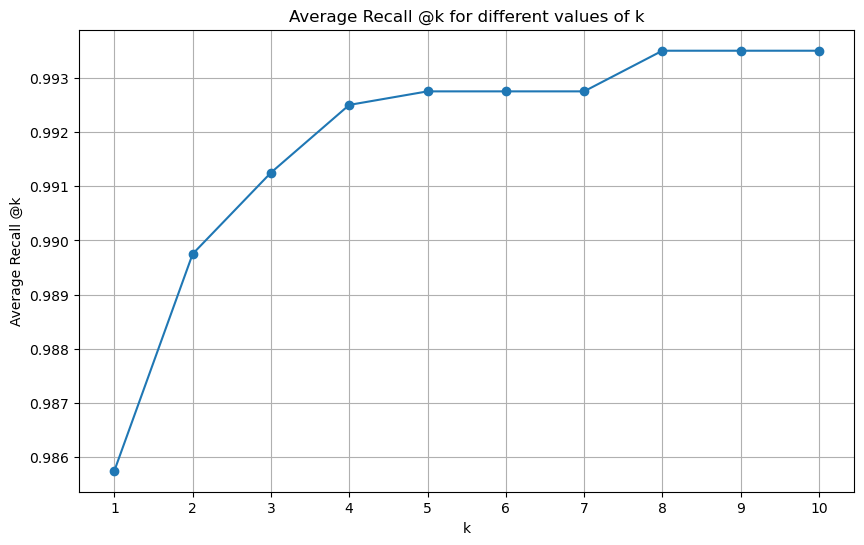

In [34]:
# Function to calculate recall @k for a single query with results pre-fetched
def calculate_recall_at_k(retrieved_docs, true_doc, k):
    recall = int(true_doc in retrieved_docs[:k])
    return recall

# Function to fetch search results once and calculate recall scores for each k
def get_recall_scores(searcher, queries, true_docs, k_range):
    recall_scores = {k: [] for k in k_range}
    for query, true_doc in tqdm.tqdm(zip(queries, true_docs), total=len(queries), desc="Calculating recall scores"):
        results = searcher.search(query, k=max(k_range))
        retrieved_docs = [searcher.collection[pid] for pid, _, _ in zip(*results)]
        for k in k_range:
            recall = calculate_recall_at_k(retrieved_docs, true_doc, k)
            recall_scores[k].append(recall)
    # Consolidate recall scores by calculating the average for each k
    average_recall_scores = {k: sum(recalls)/len(recalls) for k, recalls in recall_scores.items()}
    return average_recall_scores

# Function to plot average recall @k
def plot_average_recall_k(average_recall_scores):
    k_values = list(average_recall_scores.keys())
    recall_values = list(average_recall_scores.values())

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, recall_values, marker='o')
    plt.xlabel('k')
    plt.ylabel('Average Recall @k')
    plt.title('Average Recall @k for different values of k')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

# Main execution
k_range = range(1, 11)

# Calculate and consolidate recall scores
average_recall_scores = get_recall_scores(searcher, queries, collection, k_range)

# Print average recall scores
print("Average Recall @k:", average_recall_scores)

# Plot average recall @k
plot_average_recall_k(average_recall_scores)

In [35]:
def plot_ngram_vs_passage_score(ngram_scores, passage_scores):
    plt.figure(figsize=(10, 6))
    plt.scatter(ngram_scores, passage_scores)
    plt.xlabel('N-gram Score')
    plt.ylabel('Passage Score')
    plt.title('N-gram Score vs Passage Score')
    plt.grid(True)
    plt.show()

Calculating N-gram and passage scores:   0%|          | 0/4000 [00:00<?, ?it/s]/Users/jonathanhu/anaconda3/envs/Retrieval/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Calculating N-gram and passage scores: 100%|██████████| 4000/4000 [03:33<00:00, 18.70it/s]


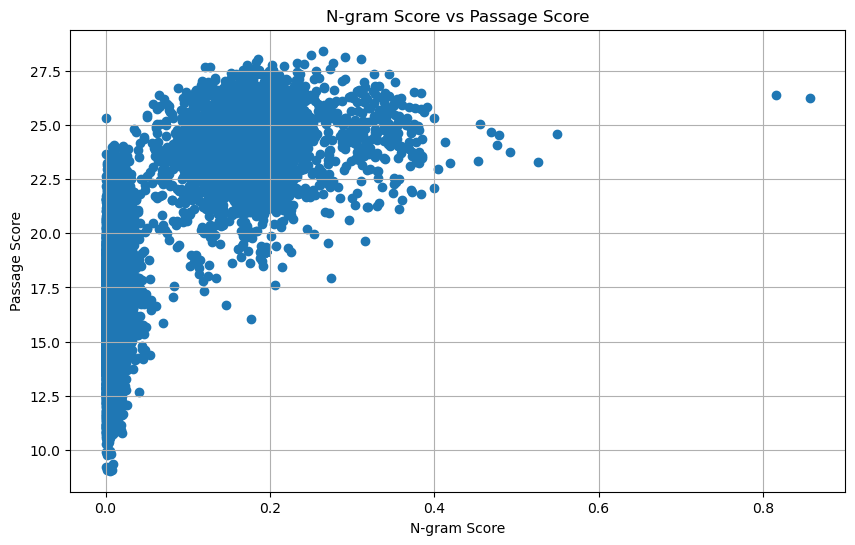

In [37]:
ngram_scores = []
passage_scores = []

for query in tqdm.tqdm(queries, desc="Calculating N-gram and passage scores"):
    results = searcher.search(query, k=10)
    for passage_id, _, passage_score in zip(*results):
        doc = searcher.collection[passage_id]
        ngram_scores.append(two_gram_overlap(query, doc))
        passage_scores.append(passage_score)

# Plot ngram score vs passage score
plot_ngram_vs_passage_score(ngram_scores, passage_scores)